In [48]:
from river import stream, tree, metrics
from river.datasets import synth
import random
from river import drift
import river
import matplotlib.pyplot as plt
import river.metrics as metrics
import river.naive_bayes as naive_bayes
import river.drift
from stream_generator import FeatureImportanceChangeGenerator
from feature_selection import run_Boruta, plot_imp_history
import numpy as np
import pandas as pd
from collections import deque

In [61]:
generator = FeatureImportanceChangeGenerator(n_features=20, n_important_features=5, random_seed=43, importance_change_interval=1)
rng = random.Random(12345)
adwin = drift.ADWIN()
hddm_a = drift.binary.HDDM_A() # average
hddm_w = drift.binary.HDDM_W() # weighted
kswin = drift.KSWIN()

In [62]:
def plot_accuracy_with_drift(epochs, accuracies, real_drift_points, detected_drift_points):
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, accuracies, label='Accuracy', color='blue')
    for i, drift in enumerate(real_drift_points):
        plt.axvline(x=drift, color='violet', linestyle='solid', 
                    label='Real Drift Occured' if i == 0 else "")
    for i, drift in enumerate(detected_drift_points):
        plt.axvline(x=drift, color='indigo', linestyle='dashed', 
                    label='Drift Detected' if i == 0 else "")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Over Time with Drift Detection")
    plt.legend()
    plt.show()

def update_metrics(model, x, y, acc, classification_report, epoch, accuracies, epochs):
    y_pred = model.predict_one(x)
    model.learn_one(x, y)
    if y_pred is not None:
        classification_report.update(y, y_pred)
        acc.update(y, y_pred)
        accuracies.append(acc.get())
        epochs.append(epoch)
    return model, y_pred

def check_drift(drift_detector, y, y_pred, epoch, print_warning):
    drift_detector.update(y == y_pred)
    drift_detected = drift_detector.drift_detected
    warning_detected = getattr(drift_detector, "warning_detected", False)

    if print_warning and warning_detected:
        print(f"Warning detected at index {epoch}, input value: {y}")

    if drift_detected:
        print(f"Drift detected at index {epoch}, input value: {y}")
    return drift_detected


In [75]:
def run_drift_detection(generator, drift_detector, boruta_samples=100, n_samples=10_000, n_history=1000, print_warning=False):
    classification_report = metrics.ClassificationReport()
    acc = metrics.Accuracy()
    model = tree.HoeffdingTreeClassifier()

    accuracies = []
    detected_drift_points = []
    epochs = []
    
    
    previous_xs, previous_ys = deque(maxlen=n_history), deque(maxlen=n_history)
    for x, y in generator.take(boruta_samples):
        previous_xs.append(x)
        previous_ys.append(y)
    
    
    boruta_result = run_Boruta(pd.DataFrame(previous_xs), np.array(previous_ys))
    accepted_features = list(boruta_result.accepted)
    accepted_features.extend(list(boruta_result.tentative))
    

    for epoch, (x, y) in enumerate(generator.take(n_samples-boruta_samples)):
        # update history
        previous_xs.append(x)
        previous_ys.append(y)
        
        # check feature importance every x epochs:
        # if epoch % n_history == 0:
        #     boruta_result = run_Boruta(pd.DataFrame(previous_xs), np.array(previous_ys))
        #     accepted_features = boruta_result.accepted
        
        # single element prediction
        important_xs = {key: value for key, value in x.items() if key in accepted_features}
        model, y_pred = update_metrics(model, important_xs, y, acc, classification_report, epoch, accuracies, epochs)

        # check drift on y
        if y_pred is not None and check_drift(drift_detector, y, y_pred, epoch, print_warning):
            boruta_result = run_Boruta(pd.DataFrame(previous_xs), np.array(previous_ys))
            accepted_features = list(boruta_result.accepted)
            accepted_features.extend(list(boruta_result.tentative))
            
            model = tree.HoeffdingTreeClassifier()
            detected_drift_points.append(epoch)
            
        if epoch % 1_000 == 0:
            print(f'Epoch {epoch}, {acc}')

    print('\n')
    print(classification_report)
    
    real_drfit_points = list(generator.importance_history.keys())
    
    plot_accuracy_with_drift(epochs, accuracies, real_drfit_points, detected_drift_points)

Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

/home/wpartycja/.local/lib/python3.10/site-packages/eBoruta/algorithm.py:431: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_.imp_history = pd.concat(


Epoch 0, Accuracy: 0.00%
Drift detected at index 252, input value: 0


Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

/home/wpartycja/.local/lib/python3.10/site-packages/eBoruta/algorithm.py:431: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_.imp_history = pd.concat(


Epoch 1000, Accuracy: 91.09%
Drift detected at index 1373, input value: 0


Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

/home/wpartycja/.local/lib/python3.10/site-packages/eBoruta/algorithm.py:431: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_.imp_history = pd.concat(


Epoch 2000, Accuracy: 90.99%
Drift detected at index 2718, input value: 0


Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

/home/wpartycja/.local/lib/python3.10/site-packages/eBoruta/algorithm.py:431: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_.imp_history = pd.concat(


Epoch 3000, Accuracy: 89.12%
Drift detected at index 3903, input value: 0


Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

/home/wpartycja/.local/lib/python3.10/site-packages/eBoruta/algorithm.py:431: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_.imp_history = pd.concat(


Epoch 4000, Accuracy: 86.56%
Epoch 5000, Accuracy: 81.65%
Epoch 6000, Accuracy: 77.54%
Drift detected at index 6240, input value: 1


Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

/home/wpartycja/.local/lib/python3.10/site-packages/eBoruta/algorithm.py:431: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_.imp_history = pd.concat(


Epoch 7000, Accuracy: 75.71%
Drift detected at index 7585, input value: 1


Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

/home/wpartycja/.local/lib/python3.10/site-packages/eBoruta/algorithm.py:431: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_.imp_history = pd.concat(


Drift detected at index 7938, input value: 0


Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

/home/wpartycja/.local/lib/python3.10/site-packages/eBoruta/algorithm.py:431: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_.imp_history = pd.concat(


Epoch 8000, Accuracy: 75.74%
Epoch 9000, Accuracy: 77.58%
Drift detected at index 9123, input value: 1


Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

/home/wpartycja/.local/lib/python3.10/site-packages/eBoruta/algorithm.py:431: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_.imp_history = pd.concat(




           Precision   Recall   F1       Support  
                                                  
       0      77.09%   77.62%   77.36%      4982  
       1      77.13%   76.59%   76.86%      4909  
                                                  
   Macro      77.11%   77.11%   77.11%            
   Micro      77.11%   77.11%   77.11%            
Weighted      77.11%   77.11%   77.11%            

                 77.11% accuracy                  


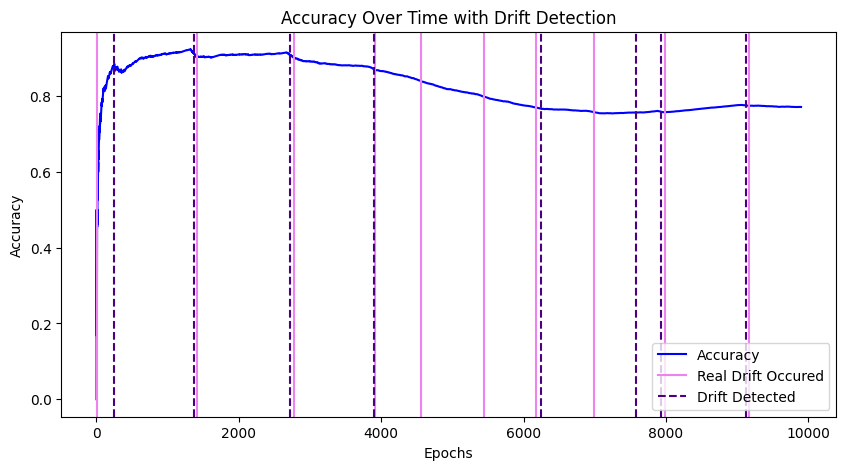

In [77]:
import random

generator = FeatureImportanceChangeGenerator(20, 5, random_seed=random.randint(0, 300), importance_change_interval=10)
run_drift_detection(generator, adwin)

In [74]:
generator.importance_history

{1: (array([ 2,  3, 10, 17, 18]),
  array([  0.        ,   0.        ,   2.76326827,  21.43757419,
          -0.        ,  -0.        ,   0.        ,   0.        ,
           0.        ,   0.        , -30.8580694 ,  -0.        ,
           0.        ,   0.        ,  -0.        ,   0.        ,
          -0.        , -14.8954715 ,  -6.15371563,   0.        ])),
 1313: (array([ 8, 12, 14, 15, 19]),
  array([ -0.        ,  -0.        ,   0.        ,  -0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
          14.60573559,  -0.        ,  -0.        ,  -0.        ,
         -13.72488933,  -0.        ,  -0.60931029,  -1.80196877,
          -0.        ,  -0.        ,  -0.        , -12.28840139])),
 2593: (array([ 3,  7, 12, 13, 15]),
  array([ 0.        ,  0.        , -0.        , 12.74619269, -0.        ,
         -0.        , -0.        ,  0.03953807, -0.        ,  0.        ,
         -0.        , -0.        , -3.6768189 , 15.50470278, -0.        ,
         14.06